In [1]:
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

from manual_model import RandomForest, SVM

In [2]:
data = pd.read_csv("data_bersih2.csv")

In [3]:
X = data.drop(columns=['skor_risiko_korupsi', 'indikator_penawar_tunggal', "indikator_prosedur_berisiko", "indikator_submisi_berisiko", "indikator_keputusan_berisiko", "konsentrasi_instansi", 'label'])

y = data['label']

In [4]:
# Split data: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y 
)

print("Jumlah data latih:", X_train.shape[0])
print("Jumlah data uji   :", X_test.shape[0])

Jumlah data latih: 79958
Jumlah data uji   : 19990


In [ ]:
non_numeric_cols = X_train.select_dtypes(include=['object']).columns
print("Kolom non-numerik:", list(non_numeric_cols))

X_train_num = X_train.drop(columns=non_numeric_cols)

from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_num, y_train)

from collections import Counter
print("Distribusi label setelah SMOTE:", Counter(y_train_resampled))

Kolom non-numerik: ['id_tender', 'judul_tender', 'jenis_prosedur', 'jenis_pengadaan', 'tanggal_kontrak', 'tanggal_keputusan_pemenang', 'status_lot', 'nama_instansi', 'negara_instansi', 'id_penyedia', 'nama_penyedia', 'tipe_penyedia', 'penyedia_menang', 'sumber_data', 'id_lot', 'id_penawaran']
Distribusi label setelah SMOTE: Counter({0: 70717, 1: 70717})


In [ ]:
data = pd.concat([X, pd.Series(y, name='label')], axis=1)

class_0 = data[data['label'] == 0]
class_1 = data[data['label'] == 1]

class_0_undersampled = class_0.sample(n=len(class_1), random_state=42)

data_balanced = pd.concat([class_0_undersampled, class_1], axis=0).sample(frac=1, random_state=42)  # acak data

X = data_balanced.drop(['id_tender', 'id_lot', 'id_penawaran', 'id_penyedia','nama_penyedia', 'judul_tender', 'nama_instansi','tanggal_kontrak', 'tanggal_keputusan_pemenang', "label"], axis=1)
y = data_balanced['label']


col_kategorikal = X.select_dtypes(include=['object']).columns

if len(col_kategorikal) > 0:
    for col in col_kategorikal:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col])
        if col in X_test.columns:
            X_test[col] = le.transform(X_test[col])

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [7]:
rf = RandomForest(n_trees=5, max_depth=5, min_samples_split=2, n_feature=5)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
print("📊 Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


📊 Random Forest Accuracy: 0.9580177450768232
              precision    recall  f1-score   support

           0       0.98      0.93      0.96      2311
           1       0.94      0.98      0.96      2310

    accuracy                           0.96      4621
   macro avg       0.96      0.96      0.96      4621
weighted avg       0.96      0.96      0.96      4621



In [8]:
# Save RF model
with open("rf_manual_model.pkl", "wb") as f:
    pickle.dump(rf, f)

Akurasi: 0.6505085479333478
Laporan Klasifikasi:
               precision    recall  f1-score   support

           0       0.69      0.55      0.61      2311
           1       0.63      0.75      0.68      2310

    accuracy                           0.65      4621
   macro avg       0.66      0.65      0.65      4621
weighted avg       0.66      0.65      0.65      4621



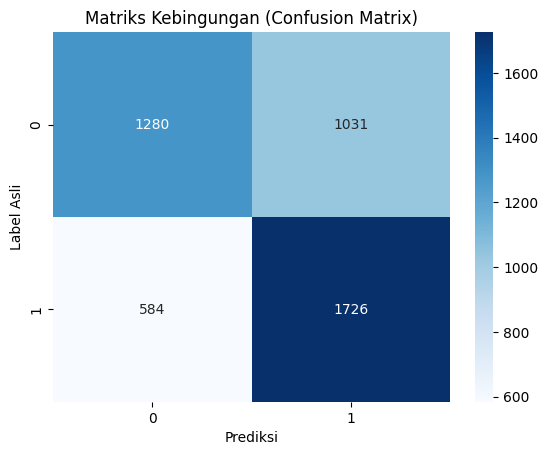

In [ ]:

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_train_svm = []
for label in y_train:
    if label == 0:
        y_train_svm.append(-1)
    else:
        y_train_svm.append(1)

y_test_svm = []
for label in y_test:
    if label == 0:
        y_test_svm.append(-1)
    else:
        y_test_svm.append(1)

svm = SVM(max_iter=500, C=5)
svm.fit(X_train, y_train_svm)

y_pred = svm.predict(X_test)

y_pred_bin = []
for p in y_pred:
    if p == -1:
        y_pred_bin.append(0)
    else:
        y_pred_bin.append(1)

y_true_bin = []
for t in y_test_svm:
    if t == -1:
        y_true_bin.append(0)
    else:
        y_true_bin.append(1)

print("Akurasi:", accuracy_score(y_true_bin, y_pred_bin))
print("Laporan Klasifikasi:\n", classification_report(y_true_bin, y_pred_bin))

# Tampilkan confusion matrix
cm = confusion_matrix(y_true_bin, y_pred_bin)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Prediksi")
plt.ylabel("Label Asli")
plt.title("Matriks Kebingungan (Confusion Matrix)")
plt.show()


In [10]:
# Save SVM model
with open("svm_manual_model.pkl", "wb") as f:
    pickle.dump(svm, f)